# **PIA IA**

### *Chest CT-Scan images Dataset*


#### Fernanda Hassel Martinez Aragon 1898637
#### Sebastian Valdes Ibarra         1896098
#### Demetrio Manuel Roa Perdomo     2077323
#### Mario Alberto Gonzalez Treviño 1948158

##**Import Libraries**

In [1]:
#Libraries
import numpy as np
import pandas as pd
import os
import PIL
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import shutil
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
#Kraggle Library
!pip install kaggle

## **Import Data**

In [4]:
from google.colab import files
files.upload()

Saving archive.zip to archive.zip


In [5]:
!mkdir ~/.kaggle
!cp archive.zip ~/.kaggle/
!chmod 600 ~/.kaggle/archive.zip

In [6]:
!kaggle datasets download -d mohamedhanyyy/chest-ctscan-images

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [7]:
!unzip /content/archive.zip

Archive:  /content/archive.zip
  inflating: Data/test/adenocarcinoma/000108 (3).png  
  inflating: Data/test/adenocarcinoma/000109 (2).png  
  inflating: Data/test/adenocarcinoma/000109 (4).png  
  inflating: Data/test/adenocarcinoma/000109 (5).png  
  inflating: Data/test/adenocarcinoma/000112 (2).png  
  inflating: Data/test/adenocarcinoma/000113 (7).png  
  inflating: Data/test/adenocarcinoma/000114 (5).png  
  inflating: Data/test/adenocarcinoma/000114.png  
  inflating: Data/test/adenocarcinoma/000115 (4).png  
  inflating: Data/test/adenocarcinoma/000115 (8).png  
  inflating: Data/test/adenocarcinoma/000115.png  
  inflating: Data/test/adenocarcinoma/000116 (5).png  
  inflating: Data/test/adenocarcinoma/000116 (7).png  
  inflating: Data/test/adenocarcinoma/000116 (9).png  
  inflating: Data/test/adenocarcinoma/000117 (4).png  
  inflating: Data/test/adenocarcinoma/000117 (8).png  
  inflating: Data/test/adenocarcinoma/000117.png  
  inflating: Data/test/adenocarcinoma/000118 (

## **Preprocessing**

In [8]:
# Ruta de la carpeta principal de datos
data_folder = '/content/Data'

# Etiquetas correspondientes a las carpetas
labels = ['adeno', 'large', 'normal', 'squa']

# Arreglo para almacenar las imágenes
images = []
# Arreglo para almacenar las etiquetas
image_labels = []

# Recorremos las subcarpetas (train, test)
for folder in ['test','train','valid']:
    # Recorremos las últimas carpetas (adeno, large, normal, squa)
    for label in labels:
        # Ruta de la carpeta actual
        folder_path = os.path.join(data_folder, folder, label)
        # Obtenemos la lista de archivos en la carpeta actual
        file_list = os.listdir(folder_path)

        # Recorremos los archivos de imagen en la carpeta actual
        for file_name in file_list:
            # Ruta completa de la imagen
            image_path = os.path.join(folder_path, file_name)
            # Cargamos la imagen utilizando OpenCV
            image = cv2.imread(image_path)

            # Si la imagen se cargó correctamente, la añadimos al arreglo images
            if image is not None:
                images.append(image)
                image_labels.append(label)

# Convertimos los arreglos en arrays de NumPy para mayor eficiencia
images = np.array(images)
image_labels = np.array(image_labels)

<ipython-input-8-0026f319bd11>:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.array(images)


In [9]:
# Definir rutas de entrenamiento, validación y prueba
train_path = '/content/Data/train'
test_path = '/content/Data/test'
val_path = '/content/Data/valid'

In [10]:
# Función para obtener el número de imágenes en cada conjunto de datos
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        # Contar el número de archivos en la carpeta
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;

train_set = GetDatasetSize(train_path)
val_set = GetDatasetSize(val_path)
test_set = GetDatasetSize(test_path)
print('Train set:', train_set)
print('Validation set:', val_set)
print('Test set:', test_set)

Train set: {'large': 115, '.ipynb_checkpoints': 0, 'normal': 148, 'adeno': 195, 'squa': 155}
Validation set: {'large': 21, '.ipynb_checkpoints': 0, 'normal': 13, 'adeno': 23, 'squa': 15}
Test set: {'large': 51, '.ipynb_checkpoints': 0, 'normal': 54, 'adeno': 120, 'squa': 90}


In [11]:
from keras.preprocessing.image import ImageDataGenerator

# Crear objeto para los datos de entrenamiento
train_data_augmentation = ImageDataGenerator(
    rescale=1.0/255.0,
    horizontal_flip=True,
    fill_mode='nearest',
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=0.4
)

train_data = train_data_augmentation.flow_from_directory(
    train_path,
    batch_size=5,
    target_size=(256, 256),
    class_mode='categorical'
)

# Crear objeto para los datos de test
test_data_augmentation = ImageDataGenerator(
    rescale=1.0/255.0
)

test_data = test_data_augmentation.flow_from_directory(
    test_path,
    batch_size=5,
    target_size=(256, 256),
    class_mode='categorical'
)

# Imprimir las clases encontradas en cada conjunto de datos
print("Clases encontradas en el conjunto de entrenamiento:", train_data.class_indices)
print("Clases encontradas en el conjunto de test:", test_data.class_indices)

Found 613 images belonging to 5 classes.
Found 315 images belonging to 5 classes.
Clases encontradas en el conjunto de entrenamiento: {'.ipynb_checkpoints': 0, 'adeno': 1, 'large': 2, 'normal': 3, 'squa': 4}
Clases encontradas en el conjunto de test: {'.ipynb_checkpoints': 0, 'adeno': 1, 'large': 2, 'normal': 3, 'squa': 4}


In [12]:
# Saving class names
class_names = ['checkpoint','adeno', 'large', 'normal','squa', ]

In [13]:
# Ruta de la carpeta principal de datos
data_folder = '/content/Data'

# Definir rutas de entrenamiento, validación y prueba
train_path = '/content/Data/train'
val_path = '/content/Data/valid'
test_path = '/content/Data/test'


# Aumentar el tamaño del conjunto de datos con técnicas de aumento de datos
train_data_augmentation = ImageDataGenerator(
    rescale=1.0 / 255.0,
    horizontal_flip=True,
    fill_mode='nearest',
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=0.4
)

val_data_augmentation = ImageDataGenerator(rescale=1.0 / 255.0)

test_data_augmentation = ImageDataGenerator(rescale=1.0 / 255.0)

train_data = train_data_augmentation.flow_from_directory(
    train_path,
    batch_size=32,  # Aumentar el tamaño del lote
    target_size=(256, 256),
    class_mode='categorical'
)

val_data = val_data_augmentation.flow_from_directory(
    val_path,
    batch_size=32,  # Aumentar el tamaño del lote
    target_size=(256, 256),
    class_mode='categorical'
)

test_data = test_data_augmentation.flow_from_directory(
    test_path,
    batch_size=32,  # Aumentar el tamaño del lote
    target_size=(256, 256),
    class_mode='categorical'
)

Found 613 images belonging to 5 classes.
Found 72 images belonging to 5 classes.
Found 315 images belonging to 5 classes.


## **Modeling**

In [14]:
# Definir el número de clases en tu conjunto de datos
num_classes = 5
# Utilizar una arquitectura diferente como VGG16
pretrained_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(256, 256, 3)
)

# Establecer las capas del modelo pre-entrenado como no entrenables
for layer in pretrained_model.layers:
    layer.trainable = False

# Crear el modelo secuencial
model = keras.models.Sequential()

# Agregar el modelo pre-entrenado
model.add(pretrained_model)

# Sección de clasificación
from keras.layers import Dense, Flatten, Dropout
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))  # Aumentar la tasa de Dropout para combatir el sobreajuste
model.add(Dense(len(class_names), activation='softmax'))

model.summary()

# Utilizar el optimizador Adam con una tasa de aprendizaje más alta
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Agregar el callback ModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath='/content/best_model_CNN.hdf5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

# Agregar el callback EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.01,
    patience=11,
    verbose=1,
    mode='max',
    restore_best_weights=False
)

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1024)              33555456  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 48275269 (184.16 MB)
Trainable params: 33560581 (128.02 MB)
Non-trainable params: 14714688 (56.13 MB)
_______

## **Training**

In [15]:
history = model.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    epochs=20,
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/20
19/19 [==============================] - ETA: 0s - loss: 8.1445 - accuracy: 0.3890 
Epoch 1: val_accuracy improved from -inf to 0.70312, saving model to /content/best_model_CNN.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - 375s 20s/step - loss: 8.1445 - accuracy: 0.3890 - val_loss: 0.8570 - val_accuracy: 0.7031
Epoch 2/20
19/19 [==============================] - ETA: 0s - loss: 3.5880 - accuracy: 0.4733 
Epoch 2: val_accuracy did not improve from 0.70312
19/19 [==============================] - 349s 18s/step - loss: 3.5880 - accuracy: 0.4733 - val_loss: 0.9736 - val_accuracy: 0.5625
Epoch 3/20
19/19 [==============================] - ETA: 0s - loss: 1.6751 - accuracy: 0.5628 
Epoch 3: val_accuracy did not improve from 0.70312
19/19 [==============================] - 354s 19s/step - loss: 1.6751 - accuracy: 0.5628 - val_loss: 0.7419 - val_accuracy: 0.6719
Epoch 4/20
19/19 [==============================] - ETA: 0s - loss: 0.9438 - accuracy: 0.5990 
Epoch 4: val_accuracy did not improve from 0.70312
19/19 [==============================] - 353s 19s/step - loss: 0.9438 - accuracy: 0.5990 - val_loss: 0.7752 - val_accuracy: 0.6875
Epoch 5/20
19/19 [====================

## **Results**

In [21]:
model.save('/content/CNN_model.h5')

# Cargar el modelo guardado
from keras.models import load_model
model = load_model('/content/CNN_model.h5')

# Evaluación del modelo
test_loss, test_acc = model.evaluate(test_data)

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

10/10 [==============================] - 170s 17s/step - loss: 0.8223 - accuracy: 0.6032
Test accuracy: 0.60317462682724
Test loss: 0.8222772479057312


Text(0.5, 1.0, 'Training vs validation accuracy')

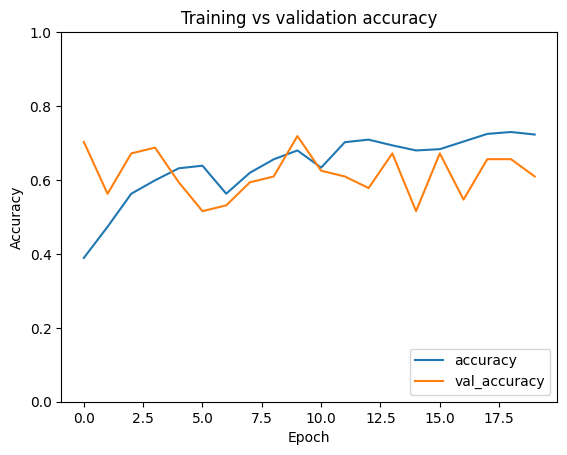

In [22]:
# Graficar la precisión de entrenamiento vs. precisión de validación durante el entrenamiento
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training vs validation accuracy')

Text(0.5, 1.0, 'Training vs validation loss')

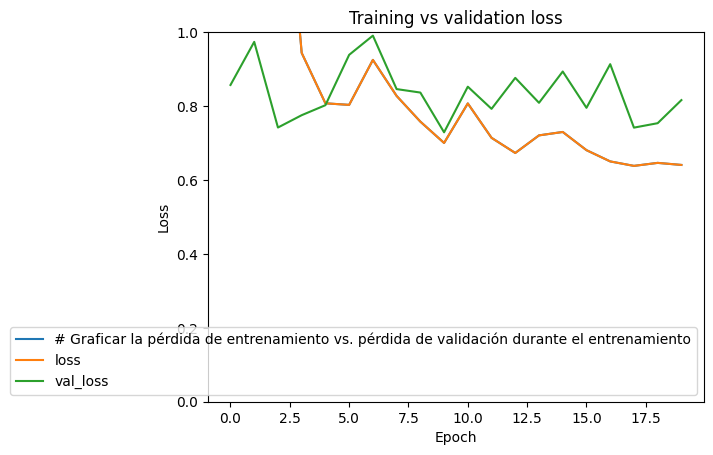

In [23]:
# Graficar la pérdida de entrenamiento vs. pérdida de validación durante el entrenamiento
plt.plot(history.history['loss'], label='# Graficar la pérdida de entrenamiento vs. pérdida de validación durante el entrenamiento')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training vs validation loss')

10/10 [==============================] - 164s 16s/step - loss: 0.7729 - accuracy: 0.6349


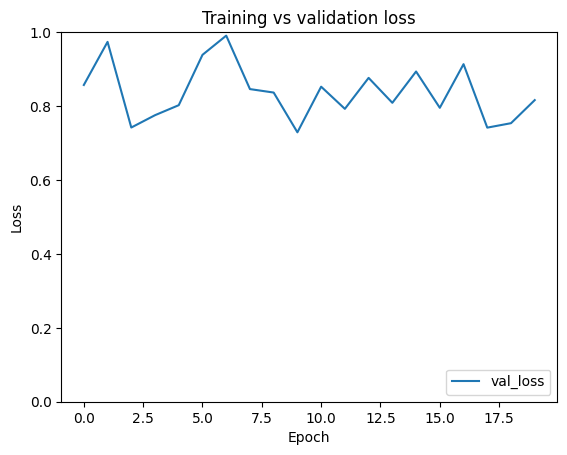

In [24]:
# Cargar el modelo en el mejor punto de control
model_best = load_model('/content/best_model_CNN.hdf5')
test_loss, test_acc = model_best.evaluate(test_data)

plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training vs validation loss')

# Cargar el modelo en el mejor punto de control
model_best = load_model('/content/best_model_CNN.hdf5')
test_loss, test_acc = model_best.evaluate(test_data)

## **Predictions**

In [25]:
model = load_model('/content/CNN_model.h5')

In [26]:
def prediction_fn(path, _model, classes_dir):
    # Cargar imagen
    img = image.load_img(path, target_size=(256,256))
    # Normalizar imagen
    norm_img = image.img_to_array(img) / 255.0
    # Convertir imagen a matriz numpy
    input_arr_img = np.array([norm_img])
    # Obtener predicciones
    pred = np.argmax(_model.predict(input_arr_img))
    # Devolver nombre de clase
    return classes_dir[pred]

In [27]:
np.random.seed(3)

# Definir las clases disponibles
class_names = ['adeno', 'large', 'normal', 'squa']

# Vectores aleatorios que contienen rutas de imágenes para cada clase
largecell_vector = []
for i in range(2):
    path_largecell = '/content/Data/test/large'
    random_im = np.random.choice(os.listdir(path_largecell))
    largecell_vector.append(path_largecell + '/' + random_im)

adeno_vector = []
for i in range(3):
    path_adeno = '/content/Data/test/adeno'
    random_im = np.random.choice(os.listdir(path_adeno))
    adeno_vector.append(path_adeno + '/' + random_im)

normal_vector = []
for i in range(2):
    path_normal = '/content/Data/test/normal'
    random_im = np.random.choice(os.listdir(path_normal))
    normal_vector.append(path_normal + '/' + random_im)

sq_vector = []
for i in range(3):
    path_sq = '/content/Data/test/squa'
    random_im = np.random.choice(os.listdir(path_sq))
    sq_vector.append(path_sq + '/' + random_im)

1/1 [==============================] - 1s 1s/step
Predicción de /content/Data/test/large/000110.png 
La CNN predice large 
Y en realidad es large.cell.carcinoma



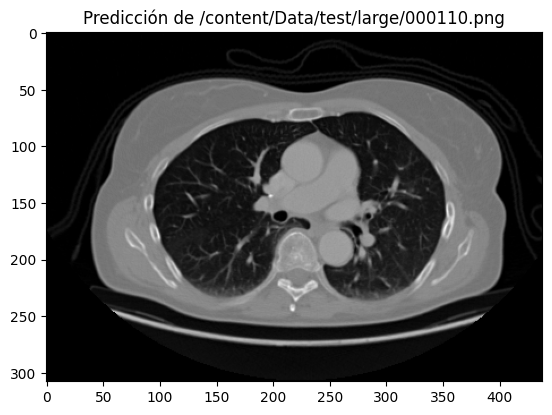

1/1 [==============================] - 0s 493ms/step
Predicción de /content/Data/test/large/000128 (2).png 
La CNN predice normal 
Y en realidad es large.cell.carcinoma



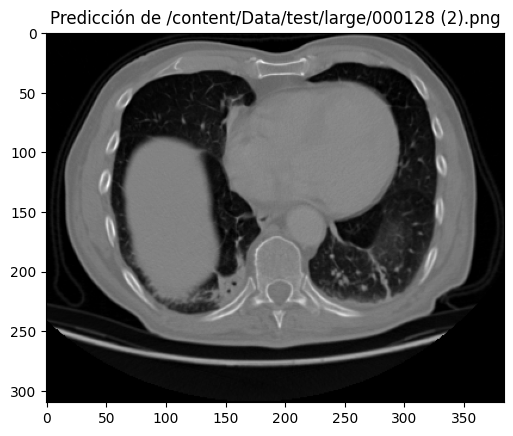

1/1 [==============================] - 1s 534ms/step
Predicción de /content/Data/test/squa/000122.png 
La CNN predice large 
Y en realidad es squamous.cell.carcinoma

1/1 [==============================] - 1s 512ms/step
Predicción de /content/Data/test/squa/000163 (6).png 
La CNN predice large 
Y en realidad es squamous.cell.carcinoma

1/1 [==============================] - 1s 522ms/step
Predicción de /content/Data/test/squa/000124 (4).png 
La CNN predice large 
Y en realidad es squamous.cell.carcinoma

1/1 [==============================] - 1s 986ms/step
Predicción de /content/Data/test/adeno/000117.png 
La CNN predice large 
Y en realidad es adenocarcinoma

1/1 [==============================] - 1s 510ms/step
Predicción de /content/Data/test/adeno/000121 (6).png 
La CNN predice large 
Y en realidad es adenocarcinoma

1/1 [==============================] - 1s 530ms/step
Predicción de /content/Data/test/adeno/000149 (4).png 
La CNN predice large 
Y en realidad es adenocarcinoma

1/1 [=

In [29]:
# Imprimir las 10 predicciones
from keras.preprocessing import image

for i in largecell_vector:
    true = prediction_fn(i, model, class_names)
    print("Predicción de", i, "\nLa CNN predice", true, "\nY en realidad es large.cell.carcinoma\n")
    test_im = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    plt.imshow(test_im, cmap='gray')
    plt.title("Predicción de " + i)
    plt.show()

for i in sq_vector:
    true = prediction_fn(i, model, class_names)
    print("Predicción de", i, "\nLa CNN predice", true, "\nY en realidad es squamous.cell.carcinoma\n")

for i in adeno_vector:
    true = prediction_fn(i, model, class_names)
    print("Predicción de", i, "\nLa CNN predice", true, "\nY en realidad es adenocarcinoma\n")

for i in normal_vector:
    true = prediction_fn(i, model, class_names)
    print("Predicción de", i, "\nLa CNN predice", true, "\nY en realidad es normal\n")